## Download dataset

In [1]:
!wget http://i13pc106.ira.uka.de/~tha/PNNProjects/sign-language-mnist.zip
!mkdir data
!unzip sign-language-mnist.zip -d data/
!rm sign-language-mnist.zip

--2021-01-17 22:41:31--  http://i13pc106.ira.uka.de/~tha/PNNProjects/sign-language-mnist.zip
Resolving i13pc106.ira.uka.de (i13pc106.ira.uka.de)... 141.3.25.106
Connecting to i13pc106.ira.uka.de (i13pc106.ira.uka.de)|141.3.25.106|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32286533 (31M) [application/zip]
Saving to: ‘sign-language-mnist.zip’

sign-language-mnist 100%[===================>]  30.79M   523KB/s    in 64s     

2021-01-17 22:42:37 (489 KB/s) - ‘sign-language-mnist.zip’ saved [32286533/32286533]

Archive:  sign-language-mnist.zip
  inflating: data/amer_sign2.png     
  inflating: data/amer_sign3.png     
  inflating: data/american_sign_language.PNG  
  inflating: data/sign_mnist_test.csv  
  inflating: data/sign_mnist_train.csv  


## Import

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from PIL import Image
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

## Device

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


## Dataset

In [4]:
DATASET_PATH = "data/sign_mnist_train.csv"

In [5]:
df_train = pd.read_csv(DATASET_PATH)

In [6]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


Each row represents an label-image pair.
- The first column is the label
- The rest 784 pixels represent the image. I.e. the size of image is 28x28x1 (WxHxC).

In [8]:
print("class: ", set(df_train.label))

class:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}


In [9]:
NUM_CLASS = len(set(df_train.label))
print("Number of classes: ", NUM_CLASS)

Number of classes:  24


In [10]:
df_train.label.value_counts()

17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
14    1196
3     1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


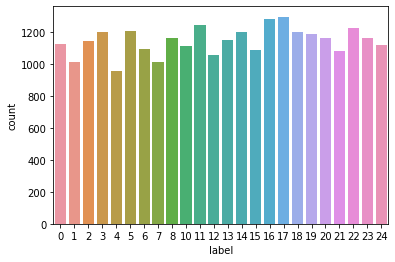

In [11]:
sns.countplot(df_train.label)

### View images

In [12]:
df_images = df_train.iloc[:, 1:]
images_np = df_images.to_numpy(dtype=np.float32)
images_np.shape

(27455, 784)

In [13]:
images_np = images_np.reshape(-1, 28, 28, 1)
images_np.shape

(27455, 28, 28, 1)

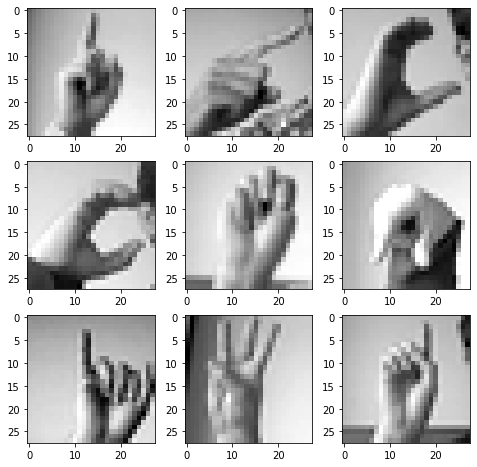

In [14]:
fig = plt.figure(figsize=(8, 8))
rows, columns = 3, 3

for i in range(rows*columns):
    img = np.reshape(images_np[i], (28, 28))
    fig.add_subplot(columns, rows, i + 1)
    plt.imshow(img, cmap='gray')

plt.show()

## Define custom dataset, transforms, and dataloaders

### Custom dataset

In [15]:
class SignLanguageMNIST(Dataset):

    def __init__(self, csv_file, phase="train", val_split=0.25, shuffle=True, transform=None, label_transform=None):
        phases = ["train", "val", "test"]
        assert phase in phases, f"Choose phase from {phases}"

        self.data = pd.read_csv(csv_file).to_numpy(np.uint8)

        train_indices, val_indices = self._train_val_split(self.data, val_split=val_split, shuffle=shuffle)
        if phase == "train":
            self.data = self.data[train_indices]
        elif phase == "val":
            self.data = self.data[val_indices]
        
        self.images = self.data[:, 1:].reshape(-1, 28, 28, 1)
        self.labels = self.data[:, 0]

        self.transform = transform
        self.label_transform = label_transform


    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        if self.label_transform:
            label = self.label_transform(label)

        label = torch.as_tensor(label, dtype=torch.long)

        return image, label


    def __len__(self):
        return len(self.labels)


    def _train_val_split(self, data, val_split=0.25, seed=42, shuffle=True):
        indices = np.arange(len(data))
        if shuffle:
            np.random.seed(seed)
            np.random.shuffle(indices)
        train_indices = indices[: int((1 - val_split) * len(indices))]
        val_indices = indices[int((1 - val_split) * len(indices)) :]

        return train_indices, val_indices


### Custom transforms

In [16]:
data_transforms = {
    "train": transforms.Compose([
        transforms.ToPILImage(),

        # data augmentation
        transforms.RandomResizedCrop(28, scale=(0.8, 1.2)),

        transforms.ToTensor(),
    ]),
    
    "val": transforms.Compose([
        transforms.ToTensor(),
    ]),
}

### Split training and validation set

In [17]:
sign_language_datasets = {x: SignLanguageMNIST(DATASET_PATH, phase=x, transform=data_transforms[x]) for x in ["train", "val"]}
dataset_sizes = {x: len(sign_language_datasets[x]) for x in ["train", "val"]}

dataset_sizes

{'train': 20591, 'val': 6864}

### Dataloaders

In [18]:
BATCH_SIZE = 32
NUM_WORKERS = 8

In [19]:
dataloaders = {x: torch.utils.data.DataLoader(sign_language_datasets[x], batch_size=BATCH_SIZE, 
                                              shuffle=True, num_workers=NUM_WORKERS) 
               for x in ['train', 'val']}

## Construct neural network

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 6, 3)
        self.conv3 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 48)
        self.fc3 = nn.Linear(48, 25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # x = x.view(-1, 16 * 5 * 5)
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3, 1)
#         self.conv2 = nn.Conv2d(32, 64, 3, 1)
#         self.dropout1 = nn.Dropout(0.25)
#         self.dropout2 = nn.Dropout(0.5)
#         self.fc1 = nn.Linear(9216, 128)
#         self.fc2 = nn.Linear(128, 25)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         return x

## Train

In [22]:
train_val_loss = {x: list() for x in ["train", "val"]}
train_val_acc = {x: list() for x in ["train", "val"]}

In [23]:
writer = SummaryWriter("runs/sign_languange")

def train(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_val_loss_dict = dict()
    train_val_acc_dict = dict()

    for epoch in range(1, num_epochs+1):
        print(f"Epoch {epoch}")
        print("-" * 10)

        for phase in ["train", "val"]:

            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for images, labels in dataloaders[phase]:
                # Move to GPU
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # track history if only in train phase
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only in trianing phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * images.shape[0]
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            train_val_loss[phase].append(epoch_loss)
            writer.add_scalar(f"Loss/{phase}", epoch_loss, epoch)

            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            train_val_acc[phase].append(epoch_acc)
            writer.add_scalar(f"Accuracy/{phase}", epoch_acc, epoch)
            
            train_val_loss_dict.update({phase: epoch_loss})
            train_val_acc_dict.update({phase: epoch_acc})

            print(f'{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

            # deep copy model weights if new best model occurs
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print("New best model!")

        writer.add_scalars("Loss: Train vs. Val", train_val_loss_dict, epoch)
        writer.add_scalars("Accuracy: Train vs. Val", train_val_acc_dict, epoch)
        print()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
        

Loss function, optimizer, and scheduler:

In [24]:
torch.manual_seed(0) # ensure reproducibility
net = Net().to(device)

criterion = nn.CrossEntropyLoss()

In [25]:
# LEARNING_RATE = 0.001
# optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Kick off training:

In [26]:
# %load_ext tensorboard
# %tensorboard --logdir=runs/sign_languange

In [27]:
trained_model = train(net, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 1
----------
train Loss: 3.1723, Acc: 0.0582
val Loss: 2.8659, Acc: 0.1329
New best model!

Epoch 2
----------
train Loss: 1.2925, Acc: 0.5761
val Loss: 0.3805, Acc: 0.8794
New best model!

Epoch 3
----------
train Loss: 0.3795, Acc: 0.8752
val Loss: 0.0811, Acc: 0.9716
New best model!

Epoch 4
----------
train Loss: 0.1876, Acc: 0.9418
val Loss: 0.0399, Acc: 0.9891
New best model!

Epoch 5
----------
train Loss: 0.1145, Acc: 0.9637
val Loss: 0.0497, Acc: 0.9830

Epoch 6
----------
train Loss: 0.0885, Acc: 0.9718
val Loss: 0.0142, Acc: 0.9971
New best model!

Epoch 7
----------
train Loss: 0.0740, Acc: 0.9775
val Loss: 0.0189, Acc: 0.9952

Epoch 8
----------
train Loss: 0.0561, Acc: 0.9827
val Loss: 0.0196, Acc: 0.9923

Epoch 9
----------
train Loss: 0.0509, Acc: 0.9838
val Loss: 0.0054, Acc: 0.9983
New best model!

Epoch 10
----------
train Loss: 0.0483, Acc: 0.9851
val Loss: 0.0052, Acc: 0.9990
New best model!

Epoch 11
----------
train Loss: 0.0187, Acc: 0.9941
val Loss: 0.000

## Test

In [28]:
TEST_SET = "data/sign_mnist_test.csv"
test_set = SignLanguageMNIST(TEST_SET, phase="test", transform=transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS) 

In [29]:
from tqdm.notebook import tqdm

correct = 0
for images, labels in tqdm(test_dataloader, desc="Testing", total=len(test_dataloader)):
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = trained_model(images)
        _, preds = _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

print(f"Accuracy on test set is {correct / len(test_set)}")


Accuracy on test set is 0.9792247629670943


## Plotting

In [47]:
import os

def save_fig(fig_name, fig_dir, tight_layout=True, fig_extension="png", resolution=300):
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    path = os.path.join(fig_dir, fig_name + "." + fig_extension)
    print("Saving figure:", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [40]:
plt.style.use('ggplot')

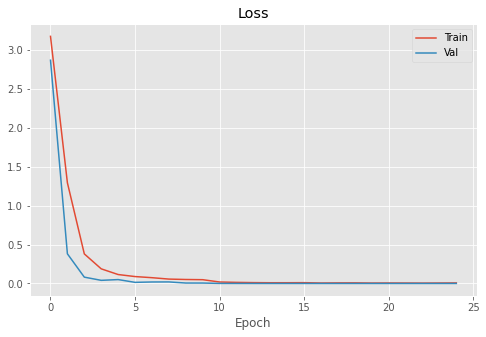

In [41]:
train_loss = np.array(train_val_loss["train"])
val_loss = np.array(train_val_loss["val"])

fig = plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Val")
plt.xlabel("Epoch")
plt.legend()
plt.title("Loss")

plt.show()

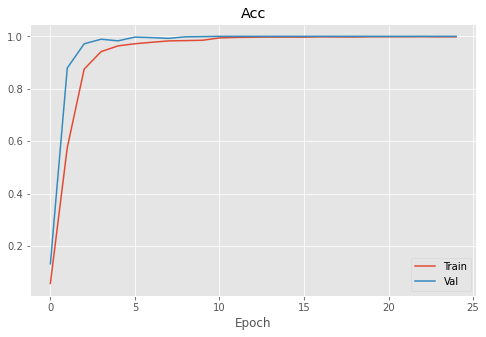

In [42]:
train_acc = np.array(train_val_acc["train"])
val_acc = np.array(train_val_acc["val"])

fig = plt.figure(figsize=(8, 5))
plt.plot(train_acc, label="Train")
plt.plot(val_acc, label="Val")
plt.xlabel("Epoch")
plt.legend()
plt.title("Acc")

plt.show()

Saving figure: loss_and_acc


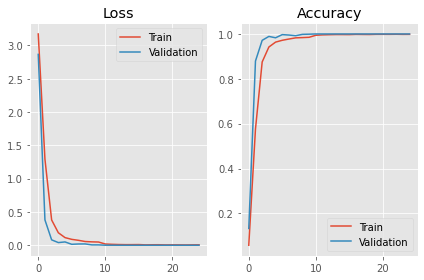

In [50]:
fig = plt.figure()

ax_loss = fig.add_subplot(1, 2, 1)
ax_loss.set_title("Loss")
ax_loss.plot(train_loss, label="Train")
ax_loss.plot(val_loss, label="Validation")
ax_loss.legend()


ax_acc = fig.add_subplot(1, 2, 2)
ax_acc.set_title("Accuracy")
ax_acc.plot(train_acc, label="Train")
ax_acc.plot(val_acc, label="Validation")
ax_acc.legend()

save_fig("loss_and_acc", "image", fig_extension="png")